# Clustering : Two dimensional normal-like mixture example

In this notebook, we estimate normal-like mixture on two-dimensional tree space by log-concave MLE. 

In [1]:
# importing packages
import lcdtreespace as lcd
import pandas as pd
import numpy as np
from importlib.resources import files
import os

## sample data

In this example, we consider following three normal-like densities:
\begin{align}
    f_1(x) &\propto \exp(-d(x,x_1)^2/16) \\
    f_2(x) &\propto \exp(-8d(x,x_2)^2) \\
    f_3(x) &\propto \exp(-8d(x,x_3)^2) 
\end{align}
where 
- $x_1$ is at the coordinate $(4,4)$ on orthant $(0,1)$
- $x_2$ is at the coordinate $(1,1)$ on orthant $(2,3)$
- $x_3$ is at the coordinate $(1,1)$ on orthant $(5,8)$

The position of true center points $x_1,x_2,x_3$ on petersen graph are displayed below.

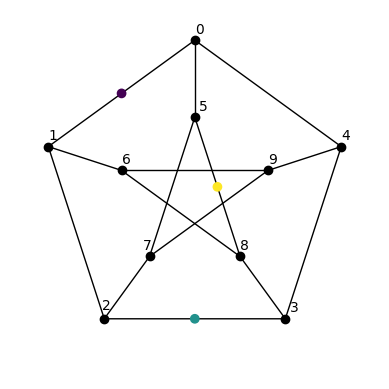

In [2]:
X = pd.DataFrame({
    "edge1" : [0,2,5],
    "edge2" : [1,3,8],
    "x1" : [4.0,1.0,1.0],
    "x2" : [4.0,1.0,1.0],
    "angle" : [np.pi/4, np.pi/4, np.pi/4],
}) # center points
fig = lcd.plot_petersen(X,c=[0,1,2])
print("")

We estimate following normal-like mixture on two-dimensional tree space:
$$f(x) \propto 0.4 f_1(x) + 0.3 f_2(x) + 0.3 f_3(x)$$

Package lcdtreespace has sample data drawn from this density at ```files("lcdtreespace").joinpath("data", "mixture")```. 

The file "cluster3_200\_{$i$}.csv" contains sample points with size 200.

Here, we compute the log-concave MLE from "cluster3_200_0.csv" file.

In [3]:
## data
np.sort(os.listdir(files("lcdtreespace").joinpath("data", "mixture")))

array(['cluster3_100_0.csv', 'cluster3_100_1.csv', 'cluster3_100_2.csv',
       'cluster3_100_3.csv', 'cluster3_100_4.csv', 'cluster3_100_5.csv',
       'cluster3_100_6.csv', 'cluster3_100_7.csv', 'cluster3_100_8.csv',
       'cluster3_100_9.csv', 'cluster3_200_0.csv', 'cluster3_200_1.csv',
       'cluster3_200_2.csv', 'cluster3_200_3.csv', 'cluster3_200_4.csv',
       'cluster3_200_5.csv', 'cluster3_200_6.csv', 'cluster3_200_7.csv',
       'cluster3_200_8.csv', 'cluster3_200_9.csv', 'cluster3_50_0.csv',
       'cluster3_50_1.csv', 'cluster3_50_2.csv', 'cluster3_50_3.csv',
       'cluster3_50_4.csv', 'cluster3_50_5.csv', 'cluster3_50_6.csv',
       'cluster3_50_7.csv', 'cluster3_50_8.csv', 'cluster3_50_9.csv'],
      dtype='<U18')

In [4]:
X = pd.read_csv(files("lcdtreespace").joinpath("data", "mixture", "cluster3_200_0.csv"))
X.head()
#edge1, edge2 represents the orthant, "x1" and "x2" are the correspoinding coordinates. "
#"angle" is given by tan(x2/x1), while "y" has initial log-likelihood (parameter to be estimated. The initiali value is not normalized to be a density nor log-concave function)
#'which' indicates the true cluster

,edge1,edge2,x1,x2,angle,y,which
0,0,1,6.480238,4.228395,0.578135,-4.035456,0
1,0,1,5.025701,4.415660,0.720874,-4.660633,0
2,0,1,5.537610,5.759309,0.805020,-3.962837,0
3,0,1,9.191394,2.220122,0.237004,-4.416781,0
4,0,1,8.162161,0.596163,0.072910,-4.386176,0


Sample points with its true cluster is displayed below: 

First plot is on petersen graph, the second one shows the positions in each orthant

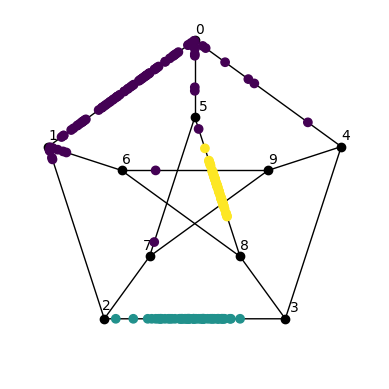

In [5]:
lcd.plot_petersen(X,c=X['which'].values)
print("")

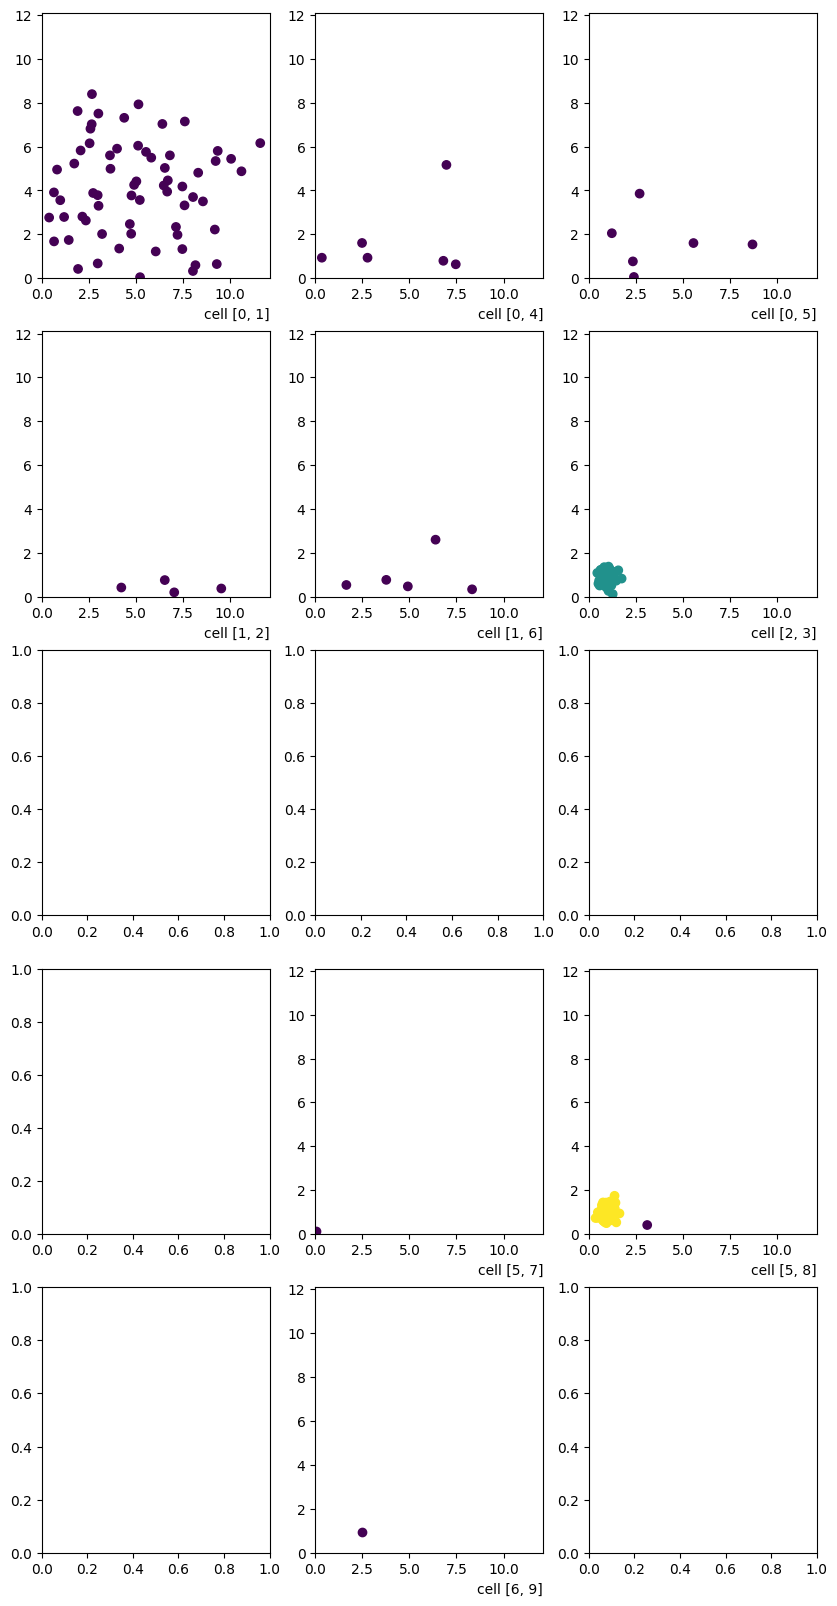

In [6]:
maximum_val = np.max(X[['x1','x2']].values)
lcd.plot_scatter_2dim(X,xmax=maximum_val+0.5,ymax=maximum_val+0.5,c=X['which'].values)
print("")

The sample points are well separated, but the difference in variance of densities make k-means clustering (minimizing sum of squared distances from allocated cluster centers) not suitable.

## Estimation by log-concave mixture

Note that estimation by log-concave mixture is computationally costly (compared to k-means approach). 

Thus, we only iterate 10 EM steps here.

The clustering by log-concave mixture can be performed using ``lcmix_cluster`` function.

In practice, due to the dependency on the initial value, lcmix_cluster should be run several times to obtain near-optimal parameters.

The computation is costly, thus we only employ one run in the following code (still can take several hours).

In [7]:
ll_best = -np.inf
for i in range(1):
    print(f"run {i}")
    pi, Y, Theta, LogLikelihoods, pi_list, Y_list = lcd.lcmix_cluster(X, n_cluster = 3,max_em_iter=10) # maximum number of em iterations is set to 10.
    if LogLikelihoods[-1] > ll_best:
        best_Theta = Theta
        best_Y = Y
        ll_best = LogLikelihoods[-1]
    print("")

run 0
iteration: 0   Loglikelihood: -1345.736309123531
iteration: 1   Loglikelihood: -912.6462362213183
iteration: 2   Loglikelihood: -897.7914856564764
iteration: 3   Loglikelihood: -875.1503994717763
iteration: 4   Loglikelihood: -850.6134757099528
iteration: 5   Loglikelihood: -830.5278122567928
iteration: 6   Loglikelihood: -803.5093680746409
iteration: 7   Loglikelihood: -781.7709621694828
iteration: 8   Loglikelihood: -758.3011717886299
iteration: 9   Loglikelihood: -755.556648736888
iteration: 10   Loglikelihood: -731.2973125168463



In [8]:
pred_labels = np.argmax(Theta,axis=1)
accuracy, indices = lcd.clustering_accuracy(X['which'].values, pred_labels)

In [9]:
pred_labels_ordered = np.vectorize(dict(zip(indices[1], indices[0])).get)(pred_labels)

In [10]:
accuracy

0.93

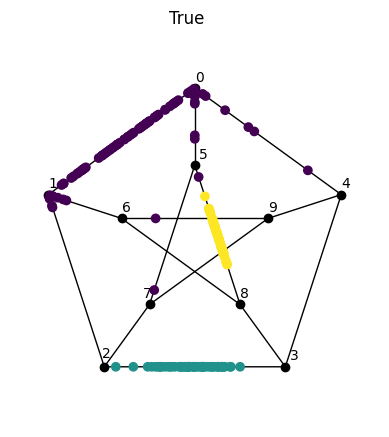

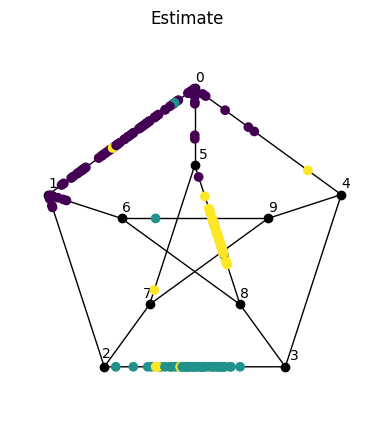

In [11]:
fig = lcd.plot_petersen(X,c=X['which'].values)
fig.suptitle("True")
fig2 = lcd.plot_petersen(X,c=pred_labels_ordered)
fig2.suptitle("Estimate")
print("")

## Estimation by K-means++
K-means++ algorithm is implemented as ```lcd.kmeans_pp```.

In [12]:
km_labels, cluster_centers = lcd.kmeans_pp(X,n_cluster=3)

/Users/Yuki/Documents/Notebook3/Git/LCDTreeSpace/src/lcdtreespace/_kmeans_pp.py:405: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(old_error - error)/np.abs(old_error) < eps:


In [15]:
km_accuracy, km_indices = lcd.clustering_accuracy(X['which'].values, km_labels)
km_labels_ordered = np.vectorize(dict(zip(km_indices[1], km_indices[0])).get)(km_labels)
km_accuracy

0.48

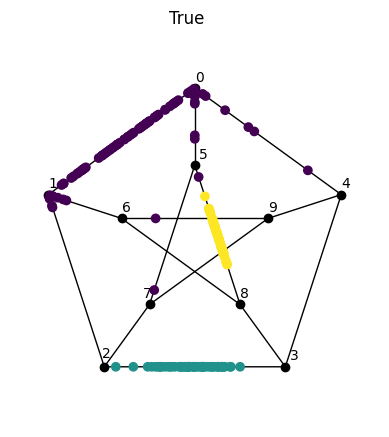

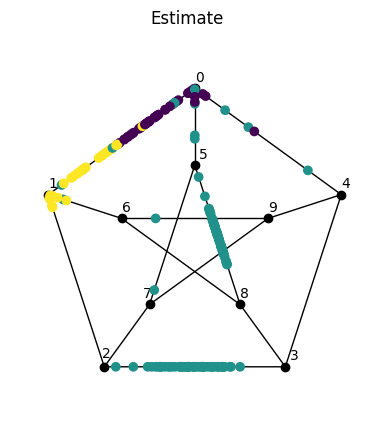

In [16]:
fig = lcd.plot_petersen(X,c=X['which'].values)
fig.suptitle("True")
fig2 = lcd.plot_petersen(X,c=km_labels_ordered)
fig2.suptitle("Estimate")
print("")